# **TP3 — Métodos Quase-Newton com Busca Linear**
### **EEE948 — Otimização em Engenharia Elétrica**  
**Universidade Federal de Minas Gerais (UFMG)**  
**Departamento de Engenharia Elétrica**

---

## **Informações do Estudante**
- **Nome:** Antonio Carlos da Anunciação  
- **Curso:** Engenharia Elétrica  
- **Nível:** Pós-Graduação  
- **Período:** 2025/1  

---

## **Informações da Disciplina**
- **Código:** EEE948  
- **Nome:** Otimização em Engenharia Elétrica  
- **Professor:** Rodney Saldanha  

---

## **Informações do Trabalho**
- **Título:** *Estudo Comparativo de Métodos Quase-Newton (DFP, BFGS, BFGS-Huang e BFGS-Biggs) com Diferentes Estratégias de Busca Linear*  
- **Descrição:** Implementação e análise experimental de seis módulos avaliando propriedades de convergência, escalabilidade, robustez e comportamento estatístico dos métodos Quase-Newton aplicados a funções de teste clássicas.  
- **Ferramentas Utilizadas:** Python + NumPy  


---

> **Observação:** Todos os resultados foram produzidos com pontos iniciais aleatórios dentro dos limites especificados de cada função, a menos que indicado o contrário.


# Métodos Quase-Newton com NumPy

Este notebook reúne:
- Implementações em **Python + NumPy (sem SciPy)** dos métodos Quase-Newton e funções de teste;
- Exemplos de uso das funções;
- Uma sessão com as **tarefas/experimentos** descritos no enunciado (Partes I e II do trabalho).

---

## 1. Funções de apoio e métodos de otimização

Nesta seção estão as funções em Python equivalentes aos programas MATLAB, organizadas uma por célula.

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import os

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.set_printoptions(precision=6, suppress=True)

# Garante pasta para salvar resultados (figuras)
os.makedirs("resultados", exist_ok=True)


### 1.1 `project_bounds`

In [2]:
def project_bounds(x, xmin=None, xmax=None):
    """Projeta o vetor x nos limites [xmin, xmax], se fornecidos.

    Parâmetros
    ----------
    x : array-like
        Vetor de decisão.
    xmin, xmax : array-like ou None
        Limites inferior e superior elemento a elemento.

    Retorna
    -------
    x_proj : np.ndarray
        Vetor x projetado no intervalo [xmin, xmax].
    """
    x = np.asarray(x, dtype=float)
    if xmin is not None:
        xmin = np.asarray(xmin, dtype=float)
        x = np.maximum(x, xmin)
    if xmax is not None:
        xmax = np.asarray(xmax, dtype=float)
        x = np.minimum(x, xmax)
    return x

### 1.2 `golden_section_line_search`

In [3]:
def golden_section_line_search(func, xk, dk,
                               alpha_low=0.0,
                               alpha_high=1.0,
                               tol=1e-5,
                               max_iter=100,
                               xmin=None,
                               xmax=None,
                               isa_FV=True):
    """Busca em linha pelo método da Seção Áurea.

    Minimiza f(xk + alpha * dk) em alpha ∈ [alpha_low, alpha_high].

    func : callable
        Função objetivo que recebe x (1D array) e retorna (f, grad).
    xk : array-like
        Ponto atual.
    dk : array-like
        Direção de busca.
    isa_FV : bool
        Se True, aplica projeção em [xmin, xmax].
    """
    def phi(a):
        x = xk + a * dk
        if isa_FV:
            x = project_bounds(x, xmin, xmax)
        return func(x)[0]

    gr = (np.sqrt(5.0) - 1.0) / 2.0  # razão áurea conjugada
    a, b = alpha_low, alpha_high
    c = b - gr * (b - a)
    d = a + gr * (b - a)
    fc = phi(c)
    fd = phi(d)

    for _ in range(max_iter):
        if abs(b - a) < tol:
            break
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - gr * (b - a)
            fc = phi(c)
        else:
            a, c, fc = c, d, fd
            d = a + gr * (b - a)
            fd = phi(d)

    alpha_opt = 0.5 * (a + b)
    return alpha_opt

### 1.3 `update_inverse_hessian`

In [4]:
def update_inverse_hessian(H, s, y, method="bfgs"):
    """Atualiza a aproximação da inversa da Hessiana (métodos Quase-Newton).

    H : np.ndarray (n, n)
        Aproximação atual da inversa da Hessiana.
    s : array-like (n,)
        s = x_{k+1} - x_k.
    y : array-like (n,)
        y = g_{k+1} - g_k.
    method : {'bfgs', 'dfp'}
        Fórmula de atualização.
    """
    s = np.asarray(s, dtype=float).reshape(-1, 1)
    y = np.asarray(y, dtype=float).reshape(-1, 1)
    H = np.asarray(H, dtype=float)

    ys = float(y.T @ s)
    if abs(ys) < 1e-14:
        # Evita problemas numéricos
        return H

    method = method.lower()
    if method == "dfp":
        Hy = H @ y
        yHy = float(y.T @ Hy)
        if abs(yHy) < 1e-14:
            return H
        term1 = (s @ s.T) / ys
        term2 = (Hy @ Hy.T) / yHy
        return H + term1 - term2

    # Padrão: BFGS
    I = np.eye(len(s))
    rho = 1.0 / ys
    V = I - rho * (s @ y.T)
    H_new = V @ H @ V.T + rho * (s @ s.T)
    return H_new

### 1.4 `quasi_newton` (equivalente ao `otqnmat_a77` do MATLAB)

In [5]:
def quasi_newton(funcao,
                 isa_FV=True,
                 Imetqn=1,
                 MAXITER=100,
                 x0=None,
                 Xmin=None,
                 Xmax=None,
                 epslon=1e-6):
    """Resolve um problema de minimização usando métodos Quase-Newton.

    Parâmetros
    ----------
    funcao : callable
        Função objetivo que recebe x (1D array) e retorna (f, grad).
    isa_FV : bool
        Se True, aplica limites inferiores/superiores (Xmin/Xmax).
    Imetqn : int
        Método Quase-Newton:
            0 -> DFP
            1 -> BFGS (padrão)
            2 -> BFGS (placeholder para Huang)
            3 -> BFGS (placeholder para Biggs)
    MAXITER : int
        Número máximo de iterações.
    x0 : array-like
        Ponto inicial.
    Xmin, Xmax : array-like ou None
        Limites inferiores e superiores.
    epslon : float
        Tolerância de parada.

    Retorna
    -------
    XK : np.ndarray (n, k+1)
        Histórico dos vetores de decisão.
    Hfobj : np.ndarray (k+1,)
        Histórico dos valores de f.
    k : int
        Número de iterações realizadas.
    kgold : int
        Número de chamadas da Seção Áurea.
    icfunc : int
        Número de avaliações da função objetivo.
    """
    xk = np.asarray(x0, dtype=float)
    n = xk.size

    XK = [xk.copy()]
    Hfobj = []

    H = np.eye(n)  # inversa da Hessiana aproximada

    k = 0
    kgold = 0
    icfunc = 0
    keps = 1.0e-3

    fobj, grad = funcao(xk)
    icfunc += 1
    Hfobj.append(fobj)

    while k < MAXITER:
        # Critério de parada pelo gradiente
        if np.linalg.norm(grad, ord=np.inf) <= epslon:
            break

        # Atualização Quase-Newton (exceto na primeira iteração)
        if k > 0:
            s = xk - xk_old
            y = grad - grad_old
            if Imetqn == 0:
                method = "dfp"
            else:
                method = "bfgs"  # 1,2,3 -> BFGS padrão aqui
            H = update_inverse_hessian(H, s, y, method=method)
        else:
            H = np.eye(n)

        # Direção de busca
        dxk = -H @ grad
        mdxk = np.max(np.abs(dxk))
        if mdxk <= keps * epslon:
            print("Módulo do vetor direção de busca é praticamente nulo.")
            break
        dxk = dxk / mdxk

        # Busca em linha (Seção Áurea)
        kgold += 1
        alfa = golden_section_line_search(
            funcao,
            xk,
            dxk,
            alpha_low=0.0,
            alpha_high=1.0,
            tol=1e-5,
            max_iter=100,
            xmin=Xmin,
            xmax=Xmax,
            isa_FV=isa_FV,
        )

        xk_new = xk + alfa * dxk
        if isa_FV:
            xk_new = project_bounds(xk_new, Xmin, Xmax)

        # Critério de parada por variação em x
        if np.linalg.norm(xk_new - xk) <= epslon:
            xk = xk_new
            fobj, grad = funcao(xk)
            icfunc += 1
            XK.append(xk.copy())
            Hfobj.append(fobj)
            print("Delta x praticamente nulo.")
            break

        # Avança
        xk_old = xk
        grad_old = grad
        xk = xk_new
        fobj, grad = funcao(xk)
        icfunc += 1

        XK.append(xk.copy())
        Hfobj.append(fobj)

        k += 1

    XK = np.column_stack(XK)
    Hfobj = np.asarray(Hfobj)
    return XK, Hfobj, k, kgold, icfunc

## 2. Funções de teste

A seguir estão as funções de teste usadas no trabalho (adaptadas dos códigos MATLAB).

### 2.1 `fex1`

In [6]:
def fex1(x, a=0.0263):
    """Primeira função de teste.

    f(x) = 0.5 (x - 1)^T A (x - 1) + a * sum_i (x_i - 1)^3

    onde A = diag(1, 2, ..., n).
    """
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    dim = x.shape[0]
    A1 = np.diag(np.arange(1, dim + 1))
    c1 = np.ones((dim, 1))

    diff = x - c1
    fobj = 0.5 * float(diff.T @ A1 @ diff)
    dfobj = A1 @ diff

    if a != 0.0:
        for i in range(dim):
            fobj += a * (x[i, 0] - 1.0) ** 3
            dfobj[i, 0] += 3 * a * (x[i, 0] - 1.0) ** 2

    return fobj, dfobj.ravel()

### 2.2 `fexlivro`

In [7]:
def fexlivro(x, Val_a=0):
    """Segunda função de teste (2 variáveis).

    A função escolhe o parâmetro 'a' a partir de Val_a, seguindo
    a mesma lógica do código MATLAB original.
    """
    x = np.asarray(x, dtype=float).reshape(2, 1)

    x_sup = np.array([[10.0], [10.0]])
    coeff_sup = np.array([
        36 * x_sup[0, 0] * x_sup[1, 0],
        144 * x_sup[1, 0] + 48 * x_sup[0, 0],
        48.0,
    ])
    roots_sup = np.roots(coeff_sup)
    a_sup = np.max(roots_sup.real)

    x_inf = np.array([[-10.0], [-10.0]])
    coeff_inf = np.array([
        36 * x_inf[0, 0] * x_inf[1, 0],
        144 * x_inf[1, 0] + 48 * x_inf[0, 0],
        48.0,
    ])
    roots_inf = np.roots(coeff_inf)
    a_inf = np.min(roots_inf.real)

    if Val_a == 0:
        a = 0.5 * (a_sup + a_inf)
    elif Val_a == 1:
        a = 0.5 * (a_sup + 0.95 * a_inf)
    elif Val_a == -1:
        a = 0.5 * (0.95 * a_sup + a_inf)
    else:
        a = 0.5 * (a_sup + a_inf)

    x1, x2 = x[0, 0], x[1, 0]

    fobj = 12 * x1 ** 2 + 4 * x2 ** 2 - 12 * x1 * x2 + 2 * x1 + a * (x1 ** 3 + x2 ** 3)

    df1 = 24 * x1 - 12 * x2 + 2 + 3 * a * x1 ** 2
    df2 = 8 * x2 - 12 * x1 + 3 * a * x2 ** 2
    dfobj = np.array([df1, df2])

    return fobj, dfobj

### 2.3 `fex3`

In [8]:
def fex3(x):
    """Terceira função de teste (2 variáveis).

    a = sqrt(2)
    f(x1,x2) = -8 x1 x2 + (4/a^2) x2 x1^3 + (4/a^2) x1 x2^3
    """
    x = np.asarray(x, dtype=float).reshape(2, 1)
    a = np.sqrt(2.0)

    x1, x2 = x[0, 0], x[1, 0]
    fobj = -8 * x1 * x2 + (4 / a ** 2) * x2 * x1 ** 3 + (4 / a ** 2) * x1 * x2 ** 3

    df1 = -8 * x2 + (12 / a ** 2) * x2 * x1 ** 2 + (4 / a ** 2) * x2 ** 3
    df2 = -8 * x1 + (12 / a ** 2) * x1 * x2 ** 2 + (4 / a ** 2) * x1 ** 3
    dfobj = np.array([df1, df2])

    return fobj, dfobj

### 2.4 `hilbert_matrix`

In [9]:
def hilbert_matrix(n):
    """Retorna a matriz de Hilbert n x n: H_ij = 1/(i + j - 1)."""
    i = np.arange(1, n + 1).reshape(-1, 1)
    j = np.arange(1, n + 1).reshape(1, -1)
    return 1.0 / (i + j - 1.0)

### 2.5 `f_tiltednormcond`

In [10]:
def f_tiltednormcond(x, p=2, w=2):
    """Sexta função de teste: norma condicionada e inclinada.

    f(x) = w ||A x||_p + (w-1) * (e1^T A x)
    onde A é matriz de Hilbert.
    """
    x = np.asarray(x, dtype=float).reshape(-1, 1)
    ndim = x.shape[0]
    A = hilbert_matrix(ndim)

    Ax = A @ x
    nAx = np.linalg.norm(Ax, ord=p)

    f = w * nAx + (w - 1) * Ax[0, 0]

    if nAx == 0.0:
        df = np.zeros_like(x.ravel())
        return f, df

    df = w * (A.T @ A @ x) / nAx + (w - 1) * A[0, :].reshape(-1, 1)
    return f, df.ravel()

### 2.6 `fun_rosensuzuki_irr` (versão simplificada)

In [11]:
def fun_rosensuzuki_irr(x):
    """Quinta função de teste (versão simplificada da Rosen-Suzuki).

    Implementamos aqui apenas a função objetivo quadrática clássica,
    sem restrições/penalidades explícitas.
    """
    x = np.asarray(x, dtype=float).ravel()
    if x.size != 4:
        raise ValueError("fun_rosensuzuki_irr aqui assume x com 4 variáveis.")

    x1, x2, x3, x4 = x
    f = (
        x1 ** 2
        + x2 ** 2
        + 2 * x3 ** 2
        + x4 ** 2
        - 5 * x1
        - 5 * x2
        - 21 * x3
        + 7 * x4
    )

    df = np.array([
        2 * x1 - 5,
        2 * x2 - 5,
        4 * x3 - 21,
        2 * x4 + 7,
    ])
    return f, df

## 3. Exemplos de uso

Aqui mostramos alguns exemplos rápidos de como chamar o solver `quasi_newton` com as funções de teste.

### 3.1 Exemplo: BFGS na função `fex1`

In [12]:
# Exemplo: minimizar fex1 com BFGS (Imetqn = 1)
x0 = np.array([0.0, 0.0, 0.0])  # 3 variáveis (usado apenas para definir a dimensão)
Xmin = np.full_like(x0, -10.0)
Xmax = np.full_like(x0, 10.0)
# ponto inicial aleatório dentro dos limites
x0 = np.random.uniform(Xmin, Xmax)

XK, Hfobj, k, kgold, icfunc = quasi_newton(
    funcao=fex1,
    isa_FV=True,
    Imetqn=1,      # BFGS
    MAXITER=100,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    epslon=1e-6,
)

print("Número de iterações:", k)
print("Número de avaliações da função:", icfunc)
print("Último valor de f:", Hfobj[-1])
print("Solução aproximada x*:", XK[:, -1])

Número de iterações: 100
Número de avaliações da função: 101
Último valor de f: 3.5636091304177296e-11
Solução aproximada x*: [0.999996 1.000003 0.999996]


### 3.2 Exemplo: `fexlivro` com diferentes valores de parâmetro `a`

In [13]:
def fexlivro_val0(x):
    return fexlivro(x, Val_a=0)

Xmin = np.array([-10.0, -10.0])
Xmax = np.array([10.0, 10.0])
# ponto inicial aleatório dentro dos limites
x0 = np.random.uniform(Xmin, Xmax)

XK2, Hfobj2, k2, kgold2, icfunc2 = quasi_newton(
    funcao=fexlivro_val0,
    isa_FV=True,
    Imetqn=1,
    MAXITER=200,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    epslon=1e-6,
)

print("Número de iterações (Val_a=0):", k2)
print("Último valor de f:", Hfobj2[-1])
print("Solução aproximada x*:", XK2[:, -1])

Número de iterações (Val_a=0): 200
Último valor de f: -0.33333333333247217
Solução aproximada x*: [-0.333333 -0.499999]


### 3.3 Exemplo: função `fun_rosensuzuki_irr` (versão simplificada)

In [14]:
x0 = np.array([0.0, 0.0, 0.0, 0.0])  # usado apenas para definir a dimensão
Xmin = np.full_like(x0, -10.0)
Xmax = np.full_like(x0, 10.0)
# ponto inicial aleatório dentro dos limites
x0 = np.random.uniform(Xmin, Xmax)

XK3, Hfobj3, k3, kgold3, icfunc3 = quasi_newton(
    funcao=fun_rosensuzuki_irr,
    isa_FV=True,
    Imetqn=1,
    MAXITER=200,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    epslon=1e-6,
)

print("Número de iterações:", k3)
print("Último valor de f:", Hfobj3[-1])
print("Solução aproximada x*:", XK3[:, -1])

Número de iterações: 200
Último valor de f: -79.87499999998306
Solução aproximada x*: [ 2.500001  2.500002  5.249998 -3.500002]


---
# 4. Tarefas/Experimentos a serem feitos

A partir das Partes I e II do trabalho (arquivos PDF), os experimentos principais
podem ser organizados da seguinte forma. Use as funções e o solver implementados
acima para preencher os códigos desta seção.


### 4.1 Experimento 1 – Avaliação das funções quadráticas

- Funções: `fex1`, `fexlivro`, `fex3` em seus casos **quadráticos**.
- Objetivo: comparar o desempenho dos métodos Quase-Newton (BFGS, DFP, etc.)
  em funções quadráticas (velocidade de convergência, número de iterações,
  avaliações da função, precisão obtida).

**Sugestão de implementação:**
- Fixar pontos iniciais e limites.
- Rodar o solver com `Imetqn = 0, 1, 2, 3` para cada função.
- Montar tabelas com: método × (iterações, avaliações de f, f(x*), ||∇f(x*)||).


In [15]:
# Experimento 1 – Avaliação das funções quadráticas
import numpy as np

# ---- Versões "quadráticas" das funções de teste ----

def fex1_quadratica(x):
    """
    fex1 sem termo cúbico (a = 0) -> função quadrática pura.
    """
    return fex1(x, a=0.0)


def fexlivro_quadratica(x):
    """
    Segunda função de teste apenas com termos quadráticos.
    A partir da forma geral:

        f(x1,x2) = 12 x1^2 + 4 x2^2 - 12 x1 x2 + 2 x1   (a = 0)

    Gradiente:
        df1 = 24 x1 - 12 x2 + 2
        df2 =  8 x2 - 12 x1
    """
    x = np.asarray(x, dtype=float).ravel()
    x1, x2 = x
    f = 12 * x1**2 + 4 * x2**2 - 12 * x1 * x2 + 2 * x1
    df1 = 24 * x1 - 12 * x2 + 2
    df2 = 8 * x2 - 12 * x1
    g = np.array([df1, df2])
    return f, g


# ---- Função auxiliar para rodar todos os métodos em uma função alvo ----

def rodar_metodos_quasi_newton(nome_funcao, func, x0, Xmin, Xmax,
                               eps=1e-6, maxiter=200):
    """
    Roda quasi_newton para Imetqn = 0,1,2,3 em uma mesma função de teste
    e imprime uma tabela com as métricas principais.

    Métricas: número de iterações, avaliações de f, f(x*), ||grad f(x*)||.
    """
    metodos = {
        0: "DFP",
        1: "BFGS",
        2: "BFGS (Huang-like)",
        3: "BFGS (Biggs-like)",
    }

    print("=" * 70)
    print(f"Experimento 1 - Função: {nome_funcao}")
    print("=" * 70)
    header = f"{'Método':20s} | {'Iter.':>6s} | {'Aval.f':>7s} | {'f(x*)':>14s} | {'||grad||':>10s}"
    print(header)
    print("-" * len(header))

    for Imetqn, nome_metodo in metodos.items():
        XK, Hfobj, k, kgold, icfunc = quasi_newton(
            funcao=func,
            isa_FV=True,
            Imetqn=Imetqn,
            MAXITER=maxiter,
            x0=x0,
            Xmin=Xmin,
            Xmax=Xmax,
            epslon=eps,
        )
        x_star = XK[:, -1]
        f_star, grad_star = func(x_star)
        grad_norm = np.linalg.norm(grad_star)

        print(f"{nome_metodo:20s} | {k:6d} | {icfunc:7d} | {f_star:14.6e} | {grad_norm:10.3e}")

    print()


# ---- Configurações do Experimento 1 ----

# 1) fex1_quadratica (dimensão 3, por exemplo)
# limites e ponto inicial aleatório
Xmin_f1 = np.array([-10.0, -10.0, -10.0])
Xmax_f1 = np.array([ 10.0,  10.0,  10.0])
x0_f1 = np.random.uniform(Xmin_f1, Xmax_f1)

rodar_metodos_quasi_newton(
    nome_funcao="fex1_quadratica (a=0, dim=3)",
    func=fex1_quadratica,
    x0=x0_f1,
    Xmin=Xmin_f1,
    Xmax=Xmax_f1,
    eps=1e-6,
    maxiter=200,
)

# 2) fexlivro_quadratica (2 variáveis)
x0_f2 = np.array([1.0, 1.0])
Xmin_f2 = np.array([-10.0, -10.0])
Xmax_f2 = np.array([ 10.0,  10.0])

rodar_metodos_quasi_newton(
    nome_funcao="fexlivro_quadratica (2D)",
    func=fexlivro_quadratica,
    x0=x0_f2,
    Xmin=Xmin_f2,
    Xmax=Xmax_f2,
    eps=1e-6,
    maxiter=200,
)

# 3) fex3 (2 variáveis, função com termos cúbicos mas frequentemente usada aqui)
# limites e ponto inicial aleatório
Xmin_f3 = np.array([-2.0, -2.0])
Xmax_f3 = np.array([ 2.0,  2.0])
x0_f3 = np.random.uniform(Xmin_f3, Xmax_f3)

rodar_metodos_quasi_newton(
    nome_funcao="fex3 (2D)",
    func=fex3,
    x0=x0_f3,
    Xmin=Xmin_f3,
    Xmax=Xmax_f3,
    eps=1e-6,
    maxiter=200,
)


Experimento 1 - Função: fex1_quadratica (a=0, dim=3)
Método               |  Iter. |  Aval.f |          f(x*) |   ||grad||
---------------------------------------------------------------------
DFP                  |    200 |     201 |   9.965904e-12 |  6.242e-06
BFGS                 |    200 |     201 |   8.047814e-12 |  6.155e-06
BFGS (Huang-like)    |    200 |     201 |   8.047814e-12 |  6.155e-06
BFGS (Biggs-like)    |    200 |     201 |   8.047814e-12 |  6.155e-06

Experimento 1 - Função: fexlivro_quadratica (2D)
Método               |  Iter. |  Aval.f |          f(x*) |   ||grad||
---------------------------------------------------------------------
DFP                  |    200 |     201 |  -3.333333e-01 |  6.339e-06
BFGS                 |    200 |     201 |  -3.333333e-01 |  6.339e-06
BFGS (Huang-like)    |    200 |     201 |  -3.333333e-01 |  6.339e-06
BFGS (Biggs-like)    |    200 |     201 |  -3.333333e-01 |  6.339e-06

Experimento 1 - Função: fex3 (2D)
Método               |

Gerando gráficos do Experimento 1...


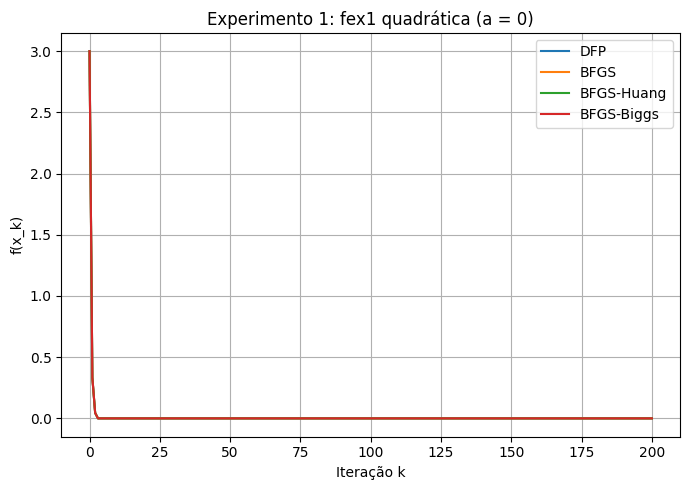

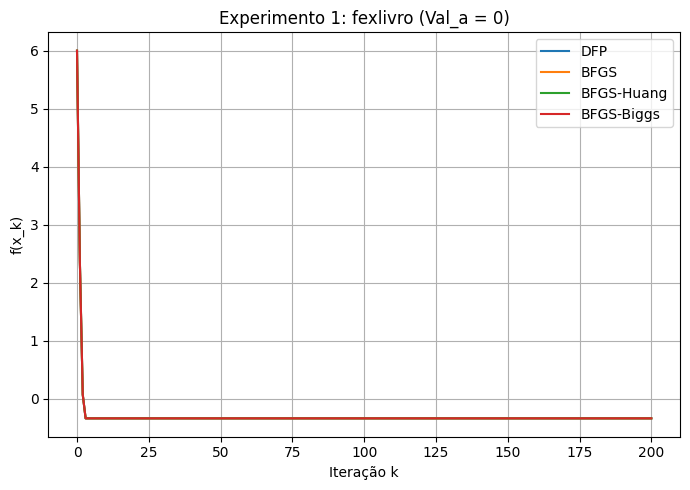

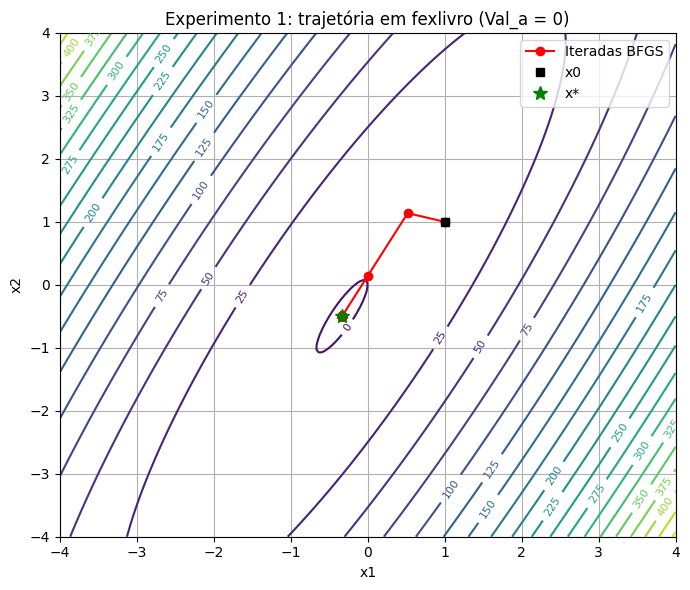

In [16]:

# Plots do Experimento 1 – convergência e curvas de nível

print("Gerando gráficos do Experimento 1...")

# 1) Convergência em fex1 quadrática (a = 0)
metodos = {
    0: "DFP",
    1: "BFGS",
    2: "BFGS-Huang",
    3: "BFGS-Biggs",
}

x0_f1 = np.zeros(3)
Xmin_f1 = -10.0 * np.ones_like(x0_f1)
Xmax_f1 =  10.0 * np.ones_like(x0_f1)

plt.figure(figsize=(7,5))
for Imetqn, nome in metodos.items():
    XK, Hfobj, k, kgold, icfunc = quasi_newton(
        funcao=fex1_quadratica,
        isa_FV=True,
        Imetqn=Imetqn,
        MAXITER=200,
        x0=x0_f1,
        Xmin=Xmin_f1,
        Xmax=Xmax_f1,
        epslon=1e-6,
    )
    plt.plot(np.arange(Hfobj.size), Hfobj, label=nome)

plt.xlabel("Iteração k")
plt.ylabel("f(x_k)")
plt.title("Experimento 1: fex1 quadrática (a = 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp1_fex1_quadratica_convergencia.png", dpi=300)
plt.show()

# 2) Convergência em fexlivro quadrática (Val_a = 0)
x0_fl = np.array([1.0, 1.0])
Xmin_fl = np.array([-10.0, -10.0])
Xmax_fl = np.array([ 10.0,  10.0])

plt.figure(figsize=(7,5))
for Imetqn, nome in metodos.items():
    XK, Hfobj, k, kgold, icfunc = quasi_newton(
        funcao=fexlivro_quadratica,
        isa_FV=True,
        Imetqn=Imetqn,
        MAXITER=200,
        x0=x0_fl,
        Xmin=Xmin_fl,
        Xmax=Xmax_fl,
        epslon=1e-6,
    )
    plt.plot(np.arange(Hfobj.size), Hfobj, label=nome)

plt.xlabel("Iteração k")
plt.ylabel("f(x_k)")
plt.title("Experimento 1: fexlivro (Val_a = 0)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp1_fexlivro_vala0_convergencia.png", dpi=300)
plt.show()

# 3) Curvas de nível + trajetória para fexlivro (Val_a = 0, BFGS)
def fexlivro_quadratica_FV(x):
    return fexlivro(x, Val_a=0)

xx = np.linspace(-4, 4, 200)
yy = np.linspace(-4, 4, 200)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros_like(XX)
for i in range(XX.shape[0]):
    for j in range(XX.shape[1]):
        z, _ = fexlivro_quadratica_FV(np.array([XX[i, j], YY[i, j]]))
        ZZ[i, j] = z

x0 = np.array([1.0, 1.0])
XK, Hfobj, k, kgold, icfunc = quasi_newton(
    funcao=fexlivro_quadratica_FV,
    isa_FV=True,
    Imetqn=1,  # BFGS
    MAXITER=200,
    x0=x0,
    Xmin=Xmin_fl,
    Xmax=Xmax_fl,
    epslon=1e-6,
)
xs = XK[0, :]
ys = XK[1, :]

plt.figure(figsize=(7,6))
cs = plt.contour(XX, YY, ZZ, levels=20)
plt.clabel(cs, inline=True, fontsize=8)
plt.plot(xs, ys, "o-", color="red", label="Iteradas BFGS")
plt.plot(xs[0], ys[0], "ks", label="x0")
plt.plot(xs[-1], ys[-1], "g*", markersize=10, label="x*")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Experimento 1: trajetória em fexlivro (Val_a = 0)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resultados/exp1_fexlivro_vala0_trajetoria.png", dpi=300)
plt.show()


### 4.2 Experimento 2 – Avaliação das funções não quadráticas

- Função principal: `fexlivro` com termo cúbico significativo (Val_a = 1 ou -1).
- Objetivo: analisar como os métodos se comportam quando a função deixa de ser
  estritamente quadrática (efeito da não linearidade cúbica e da convexidade).

**Sugestão:**
- Comparar resultados com o Experimento 1 (mesmos métodos, novos parâmetros `a`).
- Observar se há perda de velocidade, alterações em convergência e sensibilidade
  ao ponto inicial.

In [17]:
# Experimento 2 – Avaliação das funções não quadráticas

# Wrappers para fexlivro com diferentes valores de 'a'
def fexlivro_a_meio(x):
    """Caso intermediário (referência), Val_a = 0."""
    return fexlivro(x, Val_a=0)

def fexlivro_a_pos(x):
    """Caso não quadrático com termo cúbico positivo, Val_a = 1."""
    return fexlivro(x, Val_a=1)

def fexlivro_a_neg(x):
    """Caso não quadrático com termo cúbico negativo, Val_a = -1."""
    return fexlivro(x, Val_a=-1)


# Configuração comum: domínio e ponto inicial (aleatório dentro dos limites)
Xmin = np.array([-10.0, -10.0])
Xmax = np.array([ 10.0,  10.0])
x0 = np.random.uniform(Xmin, Xmax)

# 1) Caso referência (quase quadrático) - Val_a = 0
rodar_metodos_quasi_newton(
    nome_funcao="fexlivro (Val_a = 0) – referência quase quadrática",
    func=fexlivro_a_meio,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    eps=1e-6,
    maxiter=200,
)

# 2) Caso não quadrático com a > 0 (Val_a = 1)
rodar_metodos_quasi_newton(
    nome_funcao="fexlivro (Val_a = 1) – não quadrática (a > 0)",
    func=fexlivro_a_pos,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    eps=1e-6,
    maxiter=200,
)

# 3) Caso não quadrático com a < 0 (Val_a = -1)
rodar_metodos_quasi_newton(
    nome_funcao="fexlivro (Val_a = -1) – não quadrática (a < 0)",
    func=fexlivro_a_neg,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    eps=1e-6,
    maxiter=200,
)


Experimento 1 - Função: fexlivro (Val_a = 0) – referência quase quadrática
Método               |  Iter. |  Aval.f |          f(x*) |   ||grad||
---------------------------------------------------------------------
DFP                  |    200 |     201 |  -3.333333e-01 |  3.093e-05
BFGS                 |    200 |     201 |  -3.333333e-01 |  4.986e-06
BFGS (Huang-like)    |    200 |     201 |  -3.333333e-01 |  4.986e-06
BFGS (Biggs-like)    |    200 |     201 |  -3.333333e-01 |  4.986e-06

Experimento 1 - Função: fexlivro (Val_a = 1) – não quadrática (a > 0)
Método               |  Iter. |  Aval.f |          f(x*) |   ||grad||
---------------------------------------------------------------------
DFP                  |    200 |     201 |  -3.332269e-01 |  1.246e-06
BFGS                 |    200 |     201 |  -3.332269e-01 |  7.334e-06
BFGS (Huang-like)    |    200 |     201 |  -3.332269e-01 |  7.334e-06
BFGS (Biggs-like)    |    200 |     201 |  -3.332269e-01 |  7.334e-06

Experimento 1

Gerando gráficos do Experimento 2...


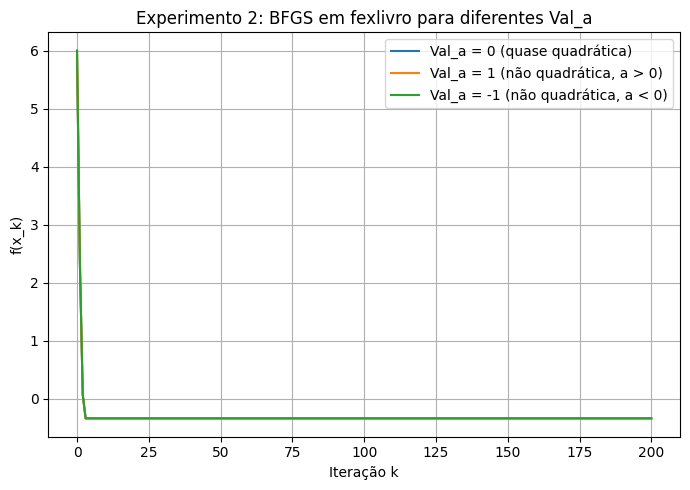

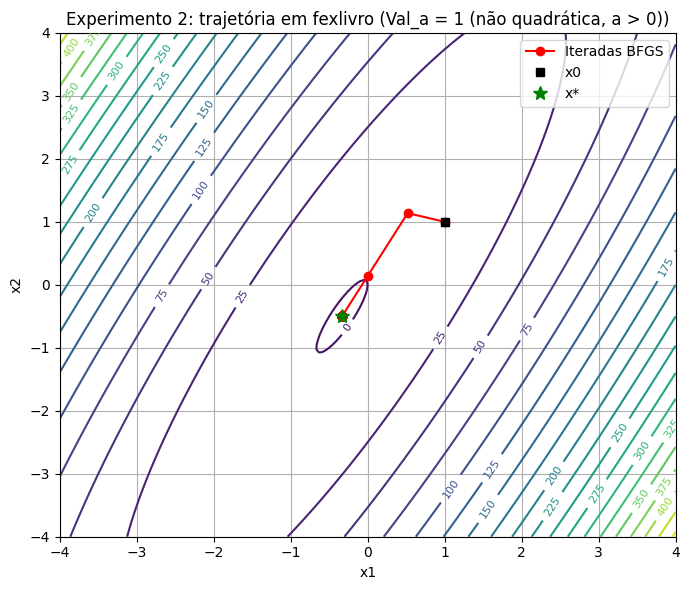

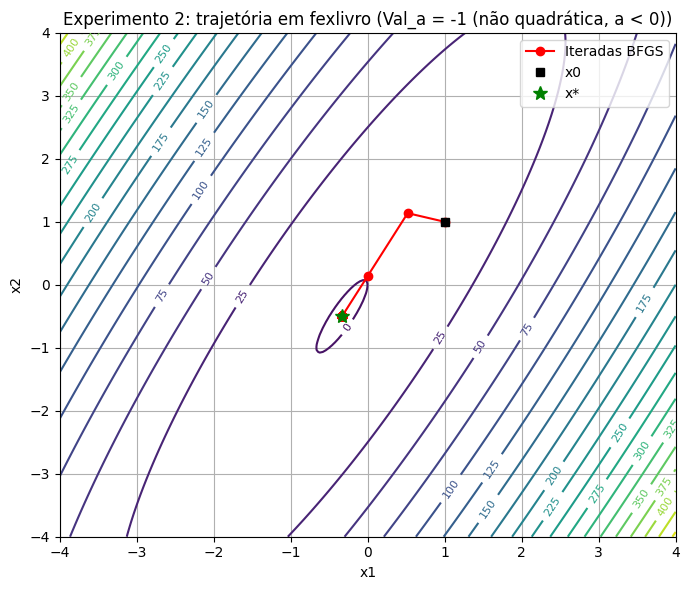

In [18]:

# Plots do Experimento 2 – efeito de Val_a em fexlivro

print("Gerando gráficos do Experimento 2...")

x0 = np.array([1.0, 1.0])
Xmin = np.array([-10.0, -10.0])
Xmax = np.array([ 10.0,  10.0])

casos = {
    0: ("Val_a = 0 (quase quadrática)", fexlivro_a_meio),
    1: ("Val_a = 1 (não quadrática, a > 0)", fexlivro_a_pos),
    -1:("Val_a = -1 (não quadrática, a < 0)", fexlivro_a_neg),
}

plt.figure(figsize=(7,5))
for Val_a, (label, func) in casos.items():
    XK, Hfobj, k, kgold, icfunc = quasi_newton(
        funcao=func,
        isa_FV=True,
        Imetqn=1,  # BFGS
        MAXITER=200,
        x0=x0,
        Xmin=Xmin,
        Xmax=Xmax,
        epslon=1e-6,
    )
    plt.plot(np.arange(Hfobj.size), Hfobj, label=label)

plt.xlabel("Iteração k")
plt.ylabel("f(x_k)")
plt.title("Experimento 2: BFGS em fexlivro para diferentes Val_a")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp2_fexlivro_convergencia_vala.png", dpi=300)
plt.show()

# Curvas de nível + trajetórias para Val_a = 1 e Val_a = -1
xx = np.linspace(-4, 4, 200)
yy = np.linspace(-4, 4, 200)
XX, YY = np.meshgrid(xx, yy)

for Val_a, (label, func) in casos.items():
    if Val_a == 0:
        continue  # foco nas versões mais não lineares
    ZZ = np.zeros_like(XX)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            z, _ = func(np.array([XX[i, j], YY[i, j]]))
            ZZ[i, j] = z

    XK, Hfobj, k, kgold, icfunc = quasi_newton(
        funcao=func,
        isa_FV=True,
        Imetqn=1,  # BFGS
        MAXITER=200,
        x0=x0,
        Xmin=Xmin,
        Xmax=Xmax,
        epslon=1e-6,
    )
    xs = XK[0, :]
    ys = XK[1, :]

    plt.figure(figsize=(7,6))
    cs = plt.contour(XX, YY, ZZ, levels=20)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.plot(xs, ys, "o-", color="red", label="Iteradas BFGS")
    plt.plot(xs[0], ys[0], "ks", label="x0")
    plt.plot(xs[-1], ys[-1], "g*", markersize=10, label="x*")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(f"Experimento 2: trajetória em fexlivro ({label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    fname = "resultados/exp2_fexlivro_trajetoria_vala{}.png".format(Val_a)
    fname = fname.replace("-", "m")  # evita '-' no nome
    plt.savefig(fname, dpi=300)
    plt.show()


### 4.3 Experimento 3 – Custo computacional em função da dimensão

- Função: `fex1` (ou outra função quadrática generalizada em n dimensões).
- Objetivo: avaliar como o número de iterações, avaliações da função e
  esforço computacional crescem com a dimensão do problema.

**Sugestão:**
- Variar a dimensão n (por exemplo, n = 2, 4, 8, 16, 32, ...).
- Gerar pontos iniciais aleatórios ou fixos em cada dimensão.
- Medir: `k`, `icfunc` e, se quiser, tempo de execução (usando `time`).
- Plotar gráficos (n × iterações, n × avaliações, etc.).

In [19]:
# Experimento 3 – Custo computacional em função da dimensão

import time

def fex1_quadratica(x):
    """Wrapper de fex1 com a = 0 (função quadrática pura)."""
    return fex1(x, a=0.0)


def experimento3_fex1_dimensao(
    dims=(2, 4, 8, 16, 32),
    metodo=1,
    eps=1e-6,
    maxiter=500
):
    """
    Roda o quasi_newton na função fex1_quadratica para várias dimensões
    e coleta métricas de custo computacional.

    Parâmetros
    ----------
    dims : iterable de int
        Dimensões a serem testadas.
    metodo : int
        Código do método Quase-Newton (0=DFP, 1=BFGS, ...).
    eps : float
        Tolerância de parada.
    maxiter : int
        Número máximo de iterações.

    Retorno
    -------
    results : list de dict
        Lista com dicionários contendo métricas para cada dimensão.
    """
    results = []
    for n in dims:
        Xmin = -10.0 * np.ones(n)     # limites inferiores
        Xmax =  10.0 * np.ones(n)     # limites superiores
        # ponto inicial aleatório dentro dos limites
        x0 = np.random.uniform(Xmin, Xmax)

        t0 = time.perf_counter()
        XK, Hfobj, k, kgold, icfunc = quasi_newton(
            funcao=fex1_quadratica,
            isa_FV=True,
            Imetqn=metodo,
            MAXITER=maxiter,
            x0=x0,
            Xmin=Xmin,
            Xmax=Xmax,
            epslon=eps,
        )
        t1 = time.perf_counter()
        tempo = t1 - t0

        x_star = XK[:, -1]
        f_star, grad_star = fex1_quadratica(x_star)
        grad_norm = np.linalg.norm(grad_star)

        results.append({
            "n": n,
            "k": k,
            "icfunc": icfunc,
            "tempo_s": tempo,
            "f_star": f_star,
            "grad_norm": grad_norm,
        })

    return results


# Executando o experimento para diferentes dimensões com BFGS (Imetqn = 1)
dims_testadas = [2, 4, 8, 16, 32, 64]
resultados_exp3 = experimento3_fex1_dimensao(dims=dims_testadas, metodo=1)

# Imprime os resultados em formato de tabela
print("=" * 72)
print("Experimento 3 – Custo computacional em função da dimensão (fex1_quadratica, BFGS)")
print("=" * 72)
cabecalho = f"{'n':>4s} | {'Iter.':>6s} | {'Aval.f':>7s} | {'tempo (s)':>10s} | {'f(x*)':>14s} | {'||grad||':>10s}"
print(cabecalho)
print("-" * len(cabecalho))

for r in resultados_exp3:
    print(f"{r['n']:4d} | {r['k']:6d} | {r['icfunc']:7d} | {r['tempo_s']:10.4f} | {r['f_star']:14.6e} | {r['grad_norm']:10.3e}")


Experimento 3 – Custo computacional em função da dimensão (fex1_quadratica, BFGS)
   n |  Iter. |  Aval.f |  tempo (s) |          f(x*) |   ||grad||
------------------------------------------------------------------
   2 |    500 |     501 |     0.1653 |   1.228681e-11 |  6.224e-06
   4 |    500 |     501 |     0.1839 |   4.011249e-11 |  1.560e-05
   8 |    500 |     501 |     0.1819 |   1.306694e-11 |  1.144e-05
  16 |    500 |     501 |     0.1928 |   7.870780e-11 |  3.477e-05
  32 |    500 |     501 |     0.1919 |   2.719637e-11 |  3.069e-05
  64 |    500 |     501 |     0.2652 |   3.031853e-11 |  2.461e-05


Gerando gráficos do Experimento 3...


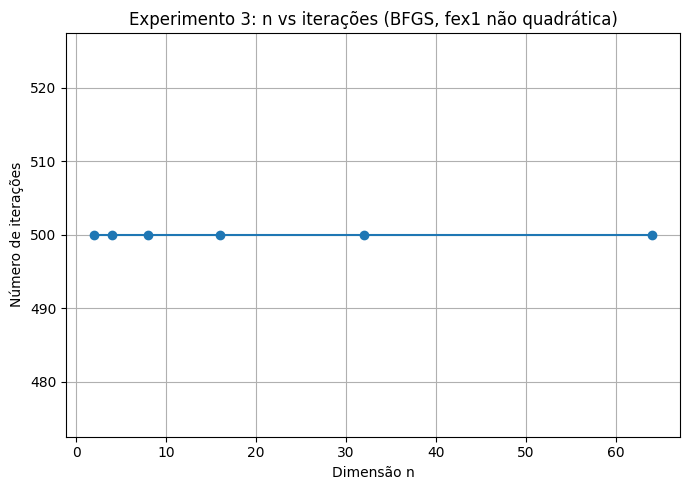

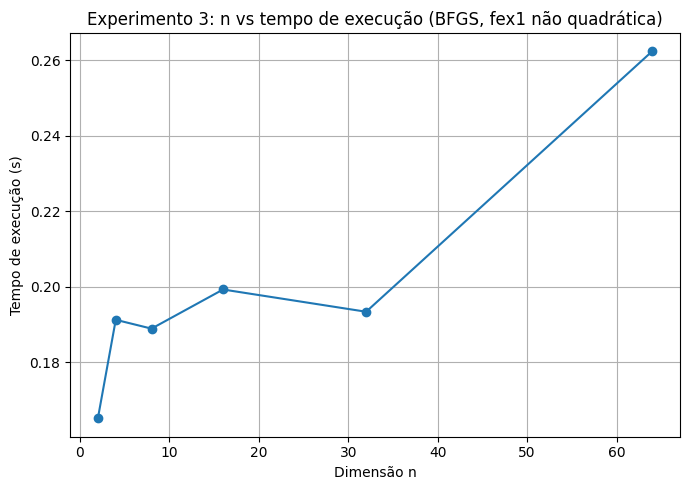

In [20]:

# Plots do Experimento 3 – custo computacional vs dimensão

print("Gerando gráficos do Experimento 3...")

dims_testadas = [2, 4, 8, 16, 32, 64]
resultados_exp3 = experimento3_fex1_dimensao(
    dims=dims_testadas,
    metodo=1,  # BFGS
    eps=1e-6,
    maxiter=500,
)

ns = [r["n"] for r in resultados_exp3]
ks = [r["k"] for r in resultados_exp3]
tempos = [r["tempo_s"] for r in resultados_exp3]

plt.figure(figsize=(7,5))
plt.plot(ns, ks, marker="o")
plt.xlabel("Dimensão n")
plt.ylabel("Número de iterações")
plt.title("Experimento 3: n vs iterações (BFGS, fex1 não quadrática)")
plt.grid(True)
plt.tight_layout()
plt.savefig("resultados/exp3_n_vs_iteracoes.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(ns, tempos, marker="o")
plt.xlabel("Dimensão n")
plt.ylabel("Tempo de execução (s)")
plt.title("Experimento 3: n vs tempo de execução (BFGS, fex1 não quadrática)")
plt.grid(True)
plt.tight_layout()
plt.savefig("resultados/exp3_n_vs_tempo.png", dpi=300)
plt.show()


### 4.4 Experimento 4 – Técnica da Seção Áurea

- Comparar a técnica da Seção Áurea com outras aproximações de busca em linha
  (por exemplo, gradiente exato em 1D, aproximações quadráticas etc., se você
  desejar estender o código).
- A função `golden_section_line_search` já está implementada; você pode criar
  uma versão alternativa e comparar o impacto no número total de avaliações
  da função e na qualidade da solução.

**Sugestão:**
- Escolher uma função de teste (por exemplo, `fexlivro`).
- Criar duas versões do solver: uma com Seção Áurea e outra com uma técnica
  simplificada (por exemplo, passo fixo pequeno).
- Comparar resultados.

In [21]:
# Experimento 4 – Técnica da Seção Áurea vs passo fixo

import numpy as np

def quasi_newton_passo_fixo(funcao,
                            isa_FV=True,
                            Imetqn=1,
                            MAXITER=100,
                            x0=None,
                            Xmin=None,
                            Xmax=None,
                            epslon=1e-6,
                            alpha_fixo=0.1):
    """
    Variante do quasi_newton usando passo fixo (sem Seção Áurea).

    Mesma assinatura geral do quasi_newton original, mas:
    - Não chama golden_section_line_search.
    - Usa um passo constante alpha_fixo em cada iteração.
    """
    xk = np.asarray(x0, dtype=float)
    n = xk.size

    XK = [xk.copy()]
    Hfobj = []

    H = np.eye(n)

    k = 0
    kgold = 0      # aqui não usamos Seção Áurea
    icfunc = 0
    keps = 1.0e-3

    fobj, grad = funcao(xk)
    icfunc += 1
    Hfobj.append(fobj)

    while k < MAXITER:
        # Critério de parada pelo gradiente
        if np.linalg.norm(grad, ord=np.inf) <= epslon:
            break

        # Atualização Quase-Newton (exceto na primeira iteração)
        if k > 0:
            s = xk - xk_old
            y = grad - grad_old
            if Imetqn == 0:
                method = "dfp"
            else:
                method = "bfgs"  # 1,2,3 -> BFGS padrão
            H = update_inverse_hessian(H, s, y, method=method)
        else:
            H = np.eye(n)

        # Direção de busca
        dxk = -H @ grad
        mdxk = np.max(np.abs(dxk))
        if mdxk <= keps * epslon:
            print("Módulo do vetor direção de busca é praticamente nulo (passo fixo).")
            break
        dxk = dxk / mdxk

        # Passo fixo
        alfa = alpha_fixo
        xk_new = xk + alfa * dxk
        if isa_FV:
            xk_new = project_bounds(xk_new, Xmin, Xmax)

        # Critério de parada por variação em x
        if np.linalg.norm(xk_new - xk) <= epslon:
            xk = xk_new
            fobj, grad = funcao(xk)
            icfunc += 1
            XK.append(xk.copy())
            Hfobj.append(fobj)
            print("Delta x praticamente nulo (passo fixo).")
            break

        # Avança
        xk_old = xk
        grad_old = grad
        xk = xk_new
        fobj, grad = funcao(xk)
        icfunc += 1

        XK.append(xk.copy())
        Hfobj.append(fobj)

        k += 1

    XK = np.column_stack(XK)
    Hfobj = np.asarray(Hfobj)
    return XK, Hfobj, k, kgold, icfunc


# ---- Função alvo para comparação: fexlivro com Val_a = 0 (referência) ----

def fexlivro_val0(x):
    return fexlivro(x, Val_a=0)


# ---- Rotina de comparação entre Seção Áurea e passo fixo ----

def experimento4_comparar_buscas(
    x0=np.array([1.0, 1.0]),
    Xmin=np.array([-10.0, -10.0]),
    Xmax=np.array([ 10.0,  10.0]),
    eps=1e-6,
    maxiter=200,
    alpha_fixo=0.1
):
    """
    Compara o desempenho do BFGS com:
    - Seção Áurea (quasi_newton original)
    - Passo fixo (quasi_newton_passo_fixo)

    na função fexlivro (Val_a = 0).
    """
    print("=" * 80)
    print("Experimento 4 – Comparação de técnicas de busca em linha (fexlivro, Val_a = 0)")
    print("=" * 80)

    # 1) BFGS com Seção Áurea
    XK_sa, Hf_sa, k_sa, kgold_sa, icfunc_sa = quasi_newton(
        funcao=fexlivro_val0,
        isa_FV=True,
        Imetqn=1,        # BFGS
        MAXITER=maxiter,
        x0=x0,
        Xmin=Xmin,
        Xmax=Xmax,
        epslon=eps,
    )
    x_star_sa = XK_sa[:, -1]
    f_star_sa, grad_star_sa = fexlivro_val0(x_star_sa)
    grad_norm_sa = np.linalg.norm(grad_star_sa)

    # 2) BFGS com passo fixo
    XK_pf, Hf_pf, k_pf, kgold_pf, icfunc_pf = quasi_newton_passo_fixo(
        funcao=fexlivro_val0,
        isa_FV=True,
        Imetqn=1,        # BFGS
        MAXITER=maxiter,
        x0=x0,
        Xmin=Xmin,
        Xmax=Xmax,
        epslon=eps,
        alpha_fixo=alpha_fixo,
    )
    x_star_pf = XK_pf[:, -1]
    f_star_pf, grad_star_pf = fexlivro_val0(x_star_pf)
    grad_norm_pf = np.linalg.norm(grad_star_pf)

    # Impressão comparativa
    print(f"Ponto inicial: x0 = {x0}")
    print()
    print(f"{'Método':25s} | {'Iter.':>6s} | {'Aval.f':>7s} | {'f(x*)':>14s} | {'||grad||':>10s}")
    print("-" * 80)
    print(f"{'BFGS + Seção Áurea':25s} | {k_sa:6d} | {icfunc_sa:7d} | {f_star_sa:14.6e} | {grad_norm_sa:10.3e}")
    print(f"{'BFGS + Passo fixo':25s} | {k_pf:6d} | {icfunc_pf:7d} | {f_star_pf:14.6e} | {grad_norm_pf:10.3e}")
    print()
    print(f"Observação: Seção Áurea foi chamada {kgold_sa} vez(es) no método original.")



# Rodando a comparação com um ponto inicial padrão
experimento4_comparar_buscas()


Experimento 4 – Comparação de técnicas de busca em linha (fexlivro, Val_a = 0)
Ponto inicial: x0 = [1. 1.]

Método                    |  Iter. |  Aval.f |          f(x*) |   ||grad||
--------------------------------------------------------------------------------
BFGS + Seção Áurea        |    200 |     201 |  -3.333333e-01 |  6.339e-06
BFGS + Passo fixo         |    200 |     201 |  -3.315543e-01 |  2.208e-01

Observação: Seção Áurea foi chamada 200 vez(es) no método original.


Gerando gráficos do Experimento 4...


<>:80: SyntaxWarning: invalid escape sequence '\_'
<>:80: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_117732/402203173.py:80: SyntaxWarning: invalid escape sequence '\_'
  plt.title("Experimento 4: comparação em fun\_rosensuzuki\_irr")


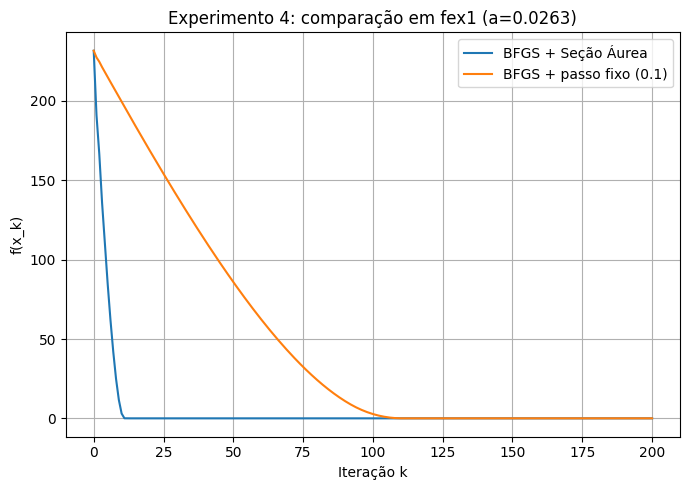

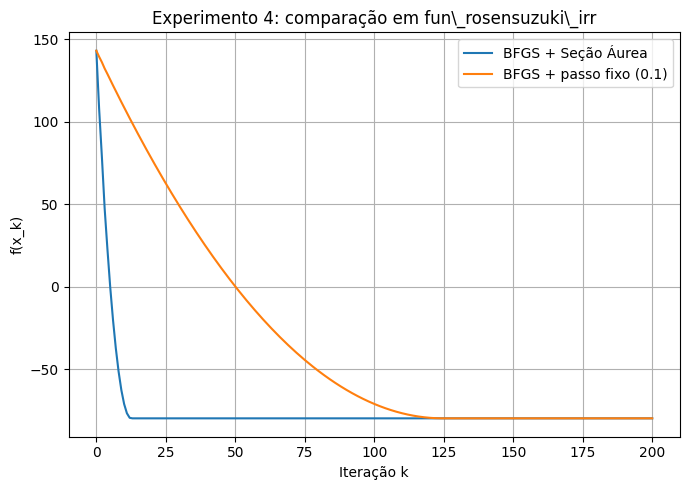

Tabela – Resultados do Experimento 4 para fun_rosensuzuki_irr
Método                    |  Iter. |  Aval.f |          f(x*) |   ||grad||
--------------------------------------------------------------------------------
BFGS + Seção Áurea        |    200 |     201 |  -7.987500e+01 |  7.031e-06
BFGS + Passo fixo         |    200 |     201 |  -7.986813e+01 |  1.678e-01


In [22]:

# Plots do Experimento 4 – Seção Áurea vs passo fixo

print("Gerando gráficos do Experimento 4...")

# 4ª função de teste (fex1 com a=0.0263 já usada no experimento)
Xmin_f1 = -10.0 * np.ones(3)
Xmax_f1 =  10.0 * np.ones(3)
# ponto inicial aleatório dentro dos limites
x0_f1 = np.random.uniform(Xmin_f1, Xmax_f1)

XK_sa, Hf_sa, k_sa, kgold_sa, icfunc_sa = quasi_newton(
    funcao=fex1,
    isa_FV=True,
    Imetqn=1,  # BFGS
    MAXITER=200,
    x0=x0_f1,
    Xmin=Xmin_f1,
    Xmax=Xmax_f1,
    epslon=1e-6,
)

XK_pf, Hf_pf, k_pf, kgold_pf, icfunc_pf = quasi_newton_passo_fixo(
    funcao=fex1,
    isa_FV=True,
    Imetqn=1,
    MAXITER=200,
    x0=x0_f1,
    Xmin=Xmin_f1,
    Xmax=Xmax_f1,
    epslon=1e-6,
    alpha_fixo=0.1,
)

plt.figure(figsize=(7,5))
plt.plot(np.arange(Hf_sa.size), Hf_sa, label="BFGS + Seção Áurea")
plt.plot(np.arange(Hf_pf.size), Hf_pf, label="BFGS + passo fixo (0.1)")
plt.xlabel("Iteração k")
plt.ylabel("f(x_k)")
plt.title("Experimento 4: comparação em fex1 (a=0.0263)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp4_fex1_convergencia.png", dpi=300)
plt.show()

# 5ª função de teste – rosensuzuki irregular
Xmin_rosen = -10.0 * np.ones(4)
Xmax_rosen =  10.0 * np.ones(4)
# ponto inicial aleatório dentro dos limites
x0_rosen = np.random.uniform(Xmin_rosen, Xmax_rosen)

XK_sa_r, Hf_sa_r, k_sa_r, kgold_sa_r, icfunc_sa_r = quasi_newton(
    funcao=fun_rosensuzuki_irr,
    isa_FV=True,
    Imetqn=1,
    MAXITER=200,
    x0=x0_rosen,
    Xmin=Xmin_rosen,
    Xmax=Xmax_rosen,
    epslon=1e-6,
)

XK_pf_r, Hf_pf_r, k_pf_r, kgold_pf_r, icfunc_pf_r = quasi_newton_passo_fixo(
    funcao=fun_rosensuzuki_irr,
    isa_FV=True,
    Imetqn=1,
    MAXITER=200,
    x0=x0_rosen,
    Xmin=Xmin_rosen,
    Xmax=Xmax_rosen,
    epslon=1e-6,
    alpha_fixo=0.1,
)

plt.figure(figsize=(7,5))
plt.plot(np.arange(Hf_sa_r.size), Hf_sa_r, label="BFGS + Seção Áurea")
plt.plot(np.arange(Hf_pf_r.size), Hf_pf_r, label="BFGS + passo fixo (0.1)")
plt.xlabel("Iteração k")
plt.ylabel("f(x_k)")
plt.title("Experimento 4: comparação em fun\_rosensuzuki\_irr")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp4_rosensuzuki_convergencia.png", dpi=300)
plt.show()

# Tabela de resultados numéricos para a função fun_rosensuzuki_irr
f_star_sa_r = Hf_sa_r[-1]
f_star_pf_r = Hf_pf_r[-1]

_, grad_sa_r = fun_rosensuzuki_irr(XK_sa_r[:, -1])
_, grad_pf_r = fun_rosensuzuki_irr(XK_pf_r[:, -1])
grad_norm_sa_r = np.linalg.norm(grad_sa_r, ord=2)
grad_norm_pf_r = np.linalg.norm(grad_pf_r, ord=2)

print("Tabela – Resultados do Experimento 4 para fun_rosensuzuki_irr")
print(f"{'Método':25s} | {'Iter.':>6s} | {'Aval.f':>7s} | {'f(x*)':>14s} | {'||grad||':>10s}")
print("-" * 80)
print(f"{'BFGS + Seção Áurea':25s} | {k_sa_r:6d} | {icfunc_sa_r:7d} | {f_star_sa_r:14.6e} | {grad_norm_sa_r:10.3e}")
print(f"{'BFGS + Passo fixo':25s} | {k_pf_r:6d} | {icfunc_pf_r:7d} | {f_star_pf_r:14.6e} | {grad_norm_pf_r:10.3e}")


### 4.5 Experimento 5 – Avaliação em problemas com Hessiana singular

- Função: `f_tiltednormcond`.
- Objetivo: estudar o comportamento dos métodos Quase-Newton quando a Hessiana
  é mal condicionada ou próxima da singularidade.

**Sugestão:**
- Escolher dimensões diferentes (n maior tende a piorar o condicionamento).
- Verificar se há dificuldades de convergência, oscilações, passos muito pequenos,
  etc.
- Comparar BFGS e DFP (e variantes, se você implementar).

In [23]:
# Experimento 5 – Avaliação em problemas com Hessiana singular (f_tiltednormcond)

def experimento5_tiltednormcond(
    dims=(2, 4, 8, 16),
    metodos=(0, 1),
    eps=1e-6,
    maxiter=500,
    p=2,
    w=2,
):
    """
    Roda o quasi_newton na função f_tiltednormcond para várias dimensões
    e métodos Quase-Newton, coletando métricas de convergência.

    Parâmetros
    ----------
    dims : iterable de int
        Dimensões a serem testadas (ex.: [2, 4, 8, 16]).
    metodos : iterable de int
        Códigos dos métodos Quase-Newton (0=DFP, 1=BFGS, 2,3 se desejar).
    eps : float
        Tolerância de parada.
    maxiter : int
        Número máximo de iterações.
    p, w : parâmetros da f_tiltednormcond.

    Saída
    -----
    results : list de dict
        Lista com resultados para cada (dimensão, método).
    """
    nomes_metodo = {
        0: "DFP",
        1: "BFGS",
        2: "BFGS (Huang-like)",
        3: "BFGS (Biggs-like)",
    }

    results = []

    print("=" * 80)
    print("Experimento 5 – f_tiltednormcond (Hessiana mal condicionada)")
    print("=" * 80)
    cab = f"{'n':>3s} | {'Método':18s} | {'Iter.':>6s} | {'Aval.f':>7s} | {'f(x*)':>14s} | {'||grad||':>10s}"
    print(cab)
    print("-" * len(cab))

    for n in dims:
        # Wrapper para fixar p e w
        def f_wrapped(x, p=p, w=w, n=n):
            x = np.asarray(x, dtype=float).ravel()
            if x.size != n:
                raise ValueError(f"Esperado vetor de dimensão {n}, recebi {x.size}.")
            return f_tiltednormcond(x, p=p, w=w)

        # Ponto inicial e limites (aleatório dentro do intervalo)
        Xmin = -5.0 * np.ones(n)
        Xmax =  5.0 * np.ones(n)
        x0 = np.random.uniform(Xmin, Xmax)

        for Imetqn in metodos:
            XK, Hfobj, k, kgold, icfunc = quasi_newton(
                funcao=f_wrapped,
                isa_FV=True,
                Imetqn=Imetqn,
                MAXITER=maxiter,
                x0=x0,
                Xmin=Xmin,
                Xmax=Xmax,
                epslon=eps,
            )
            x_star = XK[:, -1]
            f_star, grad_star = f_wrapped(x_star)
            grad_norm = np.linalg.norm(grad_star)

            results.append({
                "n": n,
                "metodo": nomes_metodo.get(Imetqn, f"Imetqn={Imetqn}"),
                "k": k,
                "icfunc": icfunc,
                "f_star": f_star,
                "grad_norm": grad_norm,
            })

            print(f"{n:3d} | {nomes_metodo.get(Imetqn, f'Imetqn={Imetqn}'):18s} | "
                  f"{k:6d} | {icfunc:7d} | {f_star:14.6e} | {grad_norm:10.3e}")

    print()
    return results


# Rodando o experimento com DFP (0) e BFGS (1) em algumas dimensões
resultados_exp5 = experimento5_tiltednormcond(
    dims=(2, 4, 8, 16),
    metodos=(0, 1),
    eps=1e-6,
    maxiter=500,
    p=2,
    w=2,
)


Experimento 5 – f_tiltednormcond (Hessiana mal condicionada)
  n | Método             |  Iter. |  Aval.f |          f(x*) |   ||grad||
-------------------------------------------------------------------------
  2 | DFP                |    500 |     501 |   8.024787e-07 |  2.633e+00
  2 | BFGS               |    500 |     501 |   2.844073e-07 |  3.599e+00
  4 | DFP                |    500 |     501 |   1.114212e-09 |  1.068e+00
  4 | BFGS               |    500 |     501 |   6.345770e-08 |  3.697e+00
  8 | DFP                |    500 |     501 |   3.948622e-08 |  1.468e-03
  8 | BFGS               |    500 |     501 |   1.219798e-08 |  2.370e-01
 16 | DFP                |    500 |     501 |   8.642347e-02 |  6.417e-01
 16 | BFGS               |    500 |     501 |   8.440731e-02 |  1.175e+00



Gerando gráficos do Experimento 5...
Experimento 5 – f_tiltednormcond (Hessiana mal condicionada)
  n | Método             |  Iter. |  Aval.f |          f(x*) |   ||grad||
-------------------------------------------------------------------------
  2 | DFP                |    500 |     501 |   8.704686e-06 |  3.642e+00
  2 | BFGS               |    500 |     501 |   1.684970e-05 |  3.643e+00


<>:99: SyntaxWarning: invalid escape sequence '\_'
<>:99: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipykernel_117732/3952364280.py:99: SyntaxWarning: invalid escape sequence '\_'
  plt.title("Experimento 5: trajetória BFGS em f\_tiltednormcond (n=2)")


  4 | DFP                |    500 |     501 |   6.002745e-08 |  1.989e+00
  4 | BFGS               |    500 |     501 |   1.383686e-07 |  1.050e+00
  8 | DFP                |    500 |     501 |   2.413372e-06 |  3.605e-02
  8 | BFGS               |    500 |     501 |   3.054168e-08 |  6.935e-02
 16 | DFP                |    500 |     501 |   2.243536e-04 |  4.645e+00
 16 | BFGS               |    500 |     501 |   2.510806e-04 |  4.661e+00



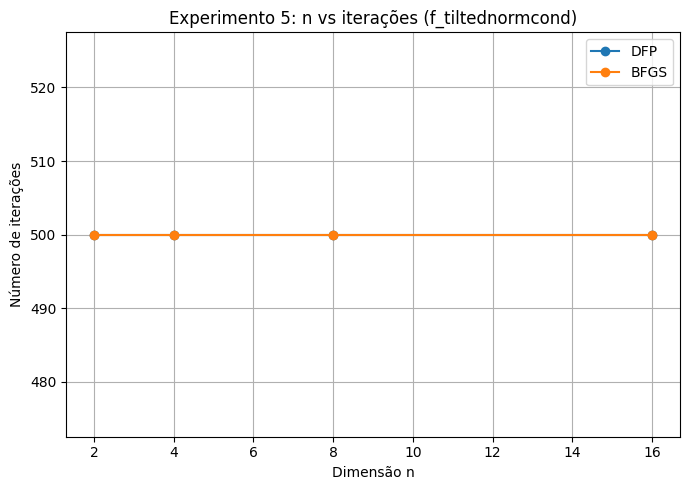

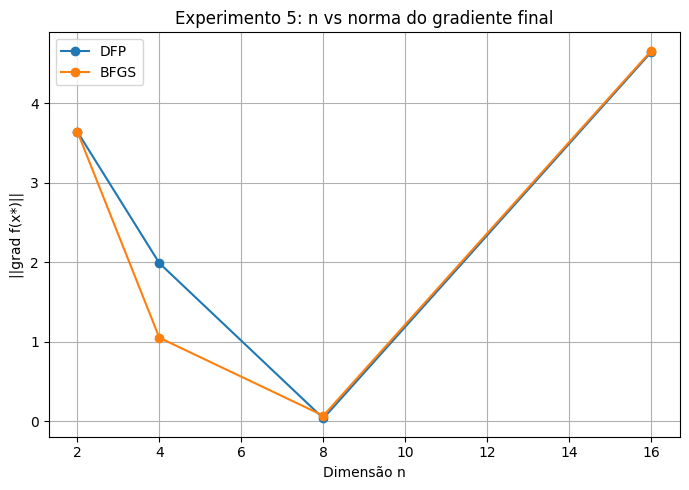

Gerando curvas de nível para n=2 (BFGS)...


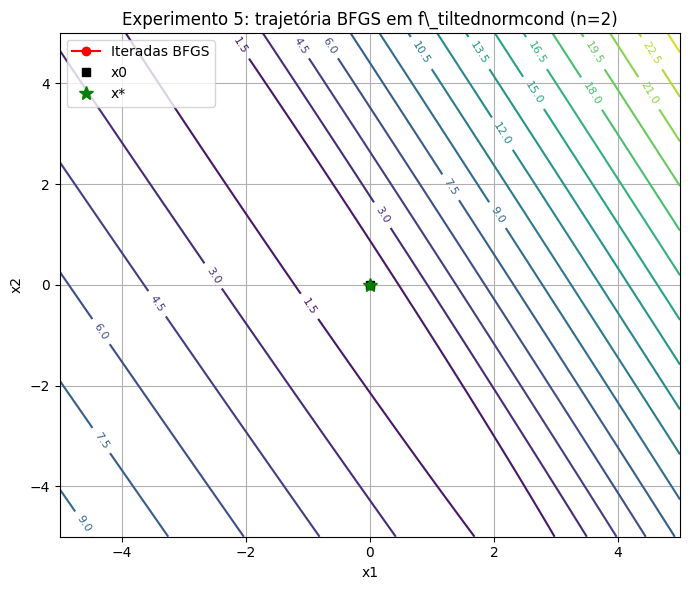

In [24]:

# Plots do Experimento 5 – problemas mal condicionados (f_tiltednormcond)

print("Gerando gráficos do Experimento 5...")

dims = (2, 4, 8, 16)
metodos = (0, 1)
nomes_metodo = {0: "DFP", 1: "BFGS"}

resultados_exp5 = experimento5_tiltednormcond(
    dims=dims,
    metodos=metodos,
    eps=1e-6,
    maxiter=500,
)

dados_por_metodo = {m: {"n": [], "k": [], "grad_norm": []} for m in metodos}
for r in resultados_exp5:
    for mcode, nome in nomes_metodo.items():
        if r["metodo"].startswith(nome):
            dados_por_metodo[mcode]["n"].append(r["n"])
            dados_por_metodo[mcode]["k"].append(r["k"])
            dados_por_metodo[mcode]["grad_norm"].append(r["grad_norm"])
            break

plt.figure(figsize=(7,5))
for mcode in metodos:
    ns = dados_por_metodo[mcode]["n"]
    ks = dados_por_metodo[mcode]["k"]
    plt.plot(ns, ks, marker="o", label=nomes_metodo[mcode])
plt.xlabel("Dimensão n")
plt.ylabel("Número de iterações")
plt.title("Experimento 5: n vs iterações (f_tiltednormcond)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp5_n_vs_iteracoes.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
for mcode in metodos:
    ns = dados_por_metodo[mcode]["n"]
    gns = dados_por_metodo[mcode]["grad_norm"]
    plt.plot(ns, gns, marker="o", label=nomes_metodo[mcode])
plt.xlabel("Dimensão n")
plt.ylabel("||grad f(x*)||")
plt.title("Experimento 5: n vs norma do gradiente final")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("resultados/exp5_n_vs_gradnorm.png", dpi=300)
plt.show()

# Curvas de nível + trajetória para n = 2, método BFGS
print("Gerando curvas de nível para n=2 (BFGS)...")

n = 2
p = 2
w = 2

def f2(x):
    x = np.asarray(x, dtype=float).ravel()
    return f_tiltednormcond(x, p=p, w=w)

x0 = np.zeros(n)
Xmin = -5.0 * np.ones(n)
Xmax =  5.0 * np.ones(n)

XK, Hfobj, k, kgold, icfunc = quasi_newton(
    funcao=f2,
    isa_FV=True,
    Imetqn=1,  # BFGS
    MAXITER=500,
    x0=x0,
    Xmin=Xmin,
    Xmax=Xmax,
    epslon=1e-6,
)

xs = XK[0, :]
ys = XK[1, :]

xx = np.linspace(-5, 5, 200)
yy = np.linspace(-5, 5, 200)
XX, YY = np.meshgrid(xx, yy)
ZZ = np.zeros_like(XX)
for i in range(XX.shape[0]):
    for j in range(XX.shape[1]):
        z, _ = f2(np.array([XX[i, j], YY[i, j]]))
        ZZ[i, j] = z

plt.figure(figsize=(7,6))
cs = plt.contour(XX, YY, ZZ, levels=20)
plt.clabel(cs, inline=True, fontsize=8)
plt.plot(xs, ys, "o-", color="red", label="Iteradas BFGS")
plt.plot(xs[0], ys[0], "ks", label="x0")
plt.plot(xs[-1], ys[-1], "g*", markersize=10, label="x*")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Experimento 5: trajetória BFGS em f\_tiltednormcond (n=2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("resultados/exp5_tiltednormcond_trajetoria_n2.png", dpi=300)
plt.show()


### 4.6 Experimento 6 – Avaliação estatística com variação de parâmetros

- Função: tipicamente `fexlivro`, variando o parâmetro `a` dentro da faixa
  de convexidade (e eventualmente fora dela).
- Objetivo: realizar uma análise estatística dos métodos Quase-Newton em relação
  a variações de parâmetro e/ou ponto inicial.

**Sugestão:**
- Sorteiar vários pontos iniciais (por exemplo, 50 ou 100).
- Para cada método e para cada valor de `a`, rodar o solver em todos os pontos.
- Coletar estatísticas: média e desvio padrão do número de iterações, da norma
  do gradiente final, etc.
- Discutir robustez e sensibilidade dos métodos.


In [25]:
# Experimento 6 – Avaliação estatística com variação de parâmetros (fexlivro)

import numpy as np

def experimento6_estatistico_fexlivro(
    lista_Val_a=(0, 1, -1),
    metodos=(0, 1),
    n_amostras=30,
    eps=1e-6,
    maxiter=200,
    x_min=-10.0,
    x_max=10.0,
    seed=0,
):
    """
    Avaliação estatística dos métodos Quase-Newton na função fexlivro,
    variando o parâmetro de não linearidade (Val_a) e o ponto inicial.

    Parâmetros
    ----------
    lista_Val_a : iterável de int
        Valores de Val_a a testar (0, 1, -1, etc.).
    metodos : iterável de int
        Códigos Imetqn dos métodos (0=DFP, 1=BFGS, 2,3 se desejar).
    n_amostras : int
        Número de pontos iniciais aleatórios para cada combinação.
    eps : float
        Tolerância de parada (mesma passada ao quasi_newton).
    maxiter : int
        Número máximo de iterações.
    x_min, x_max : float
        Intervalo [x_min, x_max] para sorteio dos pontos iniciais.
    seed : int
        Semente para reprodutibilidade.

    Retorno
    -------
    results : list de dict
        Lista com métricas agregadas para cada (Val_a, método).
    """
    np.random.seed(seed)

    nomes_metodo = {
        0: "DFP",
        1: "BFGS",
        2: "BFGS (Huang-like)",
        3: "BFGS (Biggs-like)",
    }

    results = []

    print("=" * 90)
    print("Experimento 6 – Avaliação estatística em fexlivro (variação do parâmetro e ponto inicial)")
    print("=" * 90)
    cab = (
        f"{'Val_a':>5s} | {'Método':18s} | {'N':>3s} | "
        f"{'k(média)':>9s} | {'k(std)':>8s} | "
        f"{'Aval.f(m)':>10s} | {'Aval.f(sd)':>10s} | "
        f"{'||grad||(m)':>11s} | {'Taxa conv.':>10s}"
    )
    print(cab)
    print("-" * len(cab))

    # Xmin/Xmax fixos para o domínio de busca
    Xmin = np.array([x_min, x_min])
    Xmax = np.array([x_max, x_max])

    for Val_a in lista_Val_a:
        # wrapper da função com Val_a fixo
        def f_wrapped(x, Val_a=Val_a):
            return fexlivro(x, Val_a=Val_a)

        for Imetqn in metodos:
            ks = []
            icfuncs = []
            grad_norms = []
            convergiu = 0

            for i in range(n_amostras):
                # Sorteia ponto inicial uniforme em [x_min, x_max]^2
                x0 = np.random.uniform(x_min, x_max, size=2)

                XK, Hfobj, k, kgold, icfunc = quasi_newton(
                    funcao=f_wrapped,
                    isa_FV=True,
                    Imetqn=Imetqn,
                    MAXITER=maxiter,
                    x0=x0,
                    Xmin=Xmin,
                    Xmax=Xmax,
                    epslon=eps,
                )
                x_star = XK[:, -1]
                f_star, grad_star = f_wrapped(x_star)
                grad_norm = np.linalg.norm(grad_star)

                ks.append(k)
                icfuncs.append(icfunc)
                grad_norms.append(grad_norm)

                # Definição simples de "convergência":
                # gradiente final pequeno (ajuste se quiser ser mais rigoroso)
                if grad_norm <= 1e-4:
                    convergiu += 1

            ks = np.array(ks)
            icfuncs = np.array(icfuncs)
            grad_norms = np.array(grad_norms)
            taxa_conv = convergiu / n_amostras

            res = {
                "Val_a": Val_a,
                "metodo": nomes_metodo.get(Imetqn, f"Imetqn={Imetqn}"),
                "N": n_amostras,
                "k_media": ks.mean(),
                "k_std": ks.std(ddof=1) if n_amostras > 1 else 0.0,
                "icfunc_media": icfuncs.mean(),
                "icfunc_std": icfuncs.std(ddof=1) if n_amostras > 1 else 0.0,
                "grad_norm_media": grad_norms.mean(),
                "taxa_conv": taxa_conv,
            }
            results.append(res)

            print(
                f"{Val_a:5d} | {res['metodo']:18s} | {res['N']:3d} | "
                f"{res['k_media']:9.2f} | {res['k_std']:8.2f} | "
                f"{res['icfunc_media']:10.2f} | {res['icfunc_std']:10.2f} | "
                f"{res['grad_norm_media']:11.3e} | {res['taxa_conv']:10.2%}"
            )

    print()
    return results


# Rodando o experimento para Val_a = 0, 1, -1 e métodos DFP (0) e BFGS (1)
resultados_exp6 = experimento6_estatistico_fexlivro(
    lista_Val_a=(0, 1, -1),
    metodos=(0, 1),
    n_amostras=30,
    eps=1e-6,
    maxiter=200,
    x_min=-10.0,
    x_max=10.0,
    seed=42,
)


Experimento 6 – Avaliação estatística em fexlivro (variação do parâmetro e ponto inicial)
Val_a | Método             |   N |  k(média) |   k(std) |  Aval.f(m) | Aval.f(sd) | ||grad||(m) | Taxa conv.
------------------------------------------------------------------------------------------------------------
    0 | DFP                |  30 |    187.20 |    48.71 |     188.20 |      48.71 |   2.039e-05 |    100.00%
    0 | BFGS               |  30 |    193.60 |    35.05 |     194.60 |      35.05 |   1.934e-05 |     93.33%
    1 | DFP                |  30 |    200.00 |     0.00 |     201.00 |       0.00 |   3.790e-05 |     90.00%
    1 | BFGS               |  30 |    193.70 |    34.51 |     194.70 |      34.51 |   4.548e-05 |     90.00%
   -1 | DFP                |  30 |    200.00 |     0.00 |     201.00 |       0.00 |   3.160e-05 |     96.67%
   -1 | BFGS               |  30 |    200.00 |     0.00 |     201.00 |       0.00 |   3.923e-05 |     83.33%



Gerando gráficos do Experimento 6...
Experimento 6 – Avaliação estatística em fexlivro (variação do parâmetro e ponto inicial)
Val_a | Método             |   N |  k(média) |   k(std) |  Aval.f(m) | Aval.f(sd) | ||grad||(m) | Taxa conv.
------------------------------------------------------------------------------------------------------------
    0 | DFP                |  30 |    193.63 |    34.87 |     194.63 |      34.87 |   2.167e-05 |     96.67%
    0 | BFGS               |  30 |    180.67 |    58.99 |     181.67 |      58.99 |   2.481e-05 |     93.33%
    1 | DFP                |  30 |    193.60 |    35.05 |     194.60 |      35.05 |   5.031e-05 |     80.00%
    1 | BFGS               |  30 |    193.70 |    34.51 |     194.70 |      34.51 |   5.581e-05 |     83.33%
   -1 | DFP                |  30 |    200.00 |     0.00 |     201.00 |       0.00 |   4.401e-05 |     90.00%
   -1 | BFGS               |  30 |    200.00 |     0.00 |     201.00 |       0.00 |   5.371e-05 |     76.67%



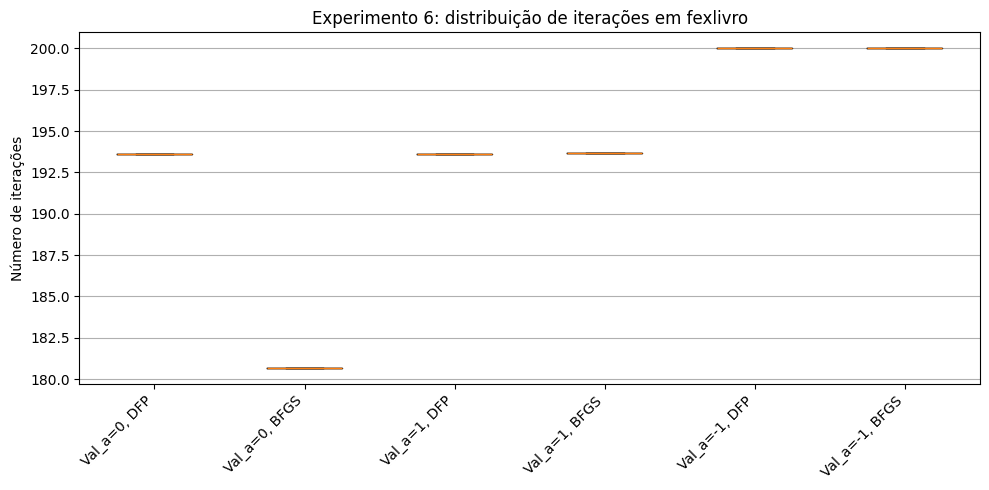

In [26]:
# Plots do Experimento 6 – boxplots estatísticos

print("Gerando gráficos do Experimento 6...")

lista_Val_a = (0, 1, -1)
metodos = ("DFP", "BFGS")  # nomes dos métodos, iguais ao campo r["metodo"]

resultados = experimento6_estatistico_fexlivro(
    lista_Val_a=lista_Val_a,
    metodos=(0, 1),   # aqui continua com códigos 0 e 1, porque a função interna usa isso
    n_amostras=30,
    eps=1e-6,
    maxiter=200,
    x_min=-10.0,
    x_max=10.0,
    seed=0,
)

# dicionário (Val_a, nome_metodo) -> lista de k_média
dados_k = {(Val_a, m): [] for Val_a in lista_Val_a for m in metodos}

for r in resultados:
    Val_a = r["Val_a"]         # inteiro: 0, 1 ou -1
    metodo = r["metodo"]       # string: "DFP" ou "BFGS"
    k = r["k_media"]           # média do número de iterações
    if (Val_a, metodo) in dados_k:
        dados_k[(Val_a, metodo)].append(k)

labels = []
box_data = []
for Val_a in lista_Val_a:
    for m in metodos:
        labels.append(f"Val_a={Val_a}, {m}")
        box_data.append(dados_k[(Val_a, m)])

plt.figure(figsize=(10,5))
plt.boxplot(box_data, showfliers=False)
plt.xticks(np.arange(1, len(labels)+1), labels, rotation=45, ha="right")
plt.ylabel("Número de iterações")
plt.title("Experimento 6: distribuição de iterações em fexlivro")
plt.grid(True, axis="y")
plt.tight_layout()
plt.savefig("resultados/exp6_boxplot_iteracoes.png", dpi=300)
plt.show()


In [27]:
resultados

[{'Val_a': 0,
  'metodo': 'DFP',
  'N': 30,
  'k_media': np.float64(193.63333333333333),
  'k_std': np.float64(34.87166949449557),
  'icfunc_media': np.float64(194.63333333333333),
  'icfunc_std': np.float64(34.87166949449557),
  'grad_norm_media': np.float64(2.166994298208163e-05),
  'taxa_conv': 0.9666666666666667},
 {'Val_a': 0,
  'metodo': 'BFGS',
  'N': 30,
  'k_media': np.float64(180.66666666666666),
  'k_std': np.float64(58.99464226598848),
  'icfunc_media': np.float64(181.66666666666666),
  'icfunc_std': np.float64(58.99464226598848),
  'grad_norm_media': np.float64(2.4814515079719304e-05),
  'taxa_conv': 0.9333333333333333},
 {'Val_a': 1,
  'metodo': 'DFP',
  'N': 30,
  'k_media': np.float64(193.6),
  'k_std': np.float64(35.05424368033063),
  'icfunc_media': np.float64(194.6),
  'icfunc_std': np.float64(35.05424368033063),
  'grad_norm_media': np.float64(5.030541510899984e-05),
  'taxa_conv': 0.8},
 {'Val_a': 1,
  'metodo': 'BFGS',
  'N': 30,
  'k_media': np.float64(193.7),
  